<a href="https://colab.research.google.com/github/BoKna031/ImageInpainting/blob/master/ImageInpaintingCIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

In [4]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10

In [5]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

In [6]:
print('Train images shape:', train_images.shape)
print('Train labels shape:', train_labels.shape)
print('Test images shape:', test_images.shape)
print('Test labels shape:', test_labels.shape)

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


Show of some pictures

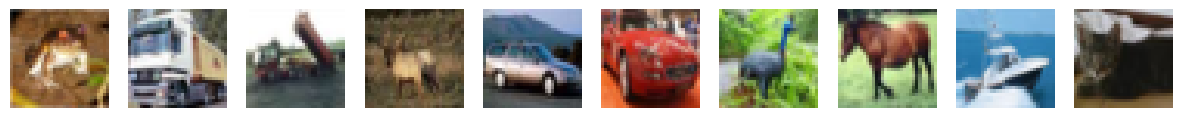

In [7]:
import matplotlib.pyplot as plt

# Prikaz prvih 10 slika iz trening skupa
fig, axes = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    axes[i].imshow(train_images[i])
    axes[i].axis('off')
plt.show()

# Preparation of Non-Blind Inpainting images

In [8]:
import os
TRAIN_DIR_NAME = "train"
TEST_DIR_NAME = "test"

NON_BLIND_IMG_DIR_NAME = "nb"
ORG_IMG_DIR_NAME = "org"
CROP_IMG_DIR_NAME = "crop"

TRAIN_ORG_PATH = TRAIN_DIR_NAME + os.sep + ORG_IMG_DIR_NAME
TRAIN_NB_PATH = TRAIN_DIR_NAME + os.sep + NON_BLIND_IMG_DIR_NAME
TRAIN_CROP_PATH = TRAIN_DIR_NAME + os.sep + CROP_IMG_DIR_NAME

TEST_ORG_PATH = TEST_DIR_NAME + os.sep + ORG_IMG_DIR_NAME
TEST_NB_PATH = TEST_DIR_NAME + os.sep + NON_BLIND_IMG_DIR_NAME
TEST_CROP_PATH = TEST_DIR_NAME + os.sep + CROP_IMG_DIR_NAME

In [9]:
import shutil

try:
  shutil.rmtree(TRAIN_DIR_NAME)
  shutil.rmtree(TEST_DIR_NAME)
  print("Directories successfully deleted.")
except FileNotFoundError:
  print("File not found!")

os.mkdir(TRAIN_DIR_NAME)
os.mkdir(TRAIN_ORG_PATH)
os.mkdir(TRAIN_NB_PATH)
os.mkdir(TRAIN_CROP_PATH)
os.mkdir(TEST_DIR_NAME)
os.mkdir(TEST_ORG_PATH)
os.mkdir(TEST_NB_PATH)
os.mkdir(TEST_CROP_PATH)
print("Empty directories successfully created.")

File not found!
Empty directories successfully created.


In [10]:
import numpy as np
import matplotlib.pyplot as plt

def non_blind_image(image):
  modified_image = np.copy(image)
  center_x = image.shape[0] // 2
  center_y = image.shape[1] // 2
  modified_image[center_x-5:center_x+5, center_y-5:center_y+5, :] = 0

  return modified_image

In [11]:
def crop_center(image):
  center_x = image.shape[0] // 2
  center_y = image.shape[1] // 2
  center_img = image[center_x-5:center_x+5, center_y-5:center_y+5, :]
  return np.copy(center_img)

In [12]:
from PIL import Image

for i, img in enumerate(train_images):
  filename = str(i) + "_" + str(train_labels[i][0])
  org_img = Image.fromarray(img)
  nb_img = Image.fromarray(non_blind_image(img))
  crop_img = Image.fromarray(crop_center(img))

  nb_img.save(TRAIN_NB_PATH + os.sep + filename + ".png")
  crop_img.save(TRAIN_CROP_PATH + os.sep + filename + ".png")
  org_img.save(TRAIN_ORG_PATH + os.sep + filename + ".png")

for i, img in enumerate(test_images):
  filename = str(i) + "_" + str(test_labels[i][0])

  org_img = Image.fromarray(img)
  nb_img = Image.fromarray(non_blind_image(img))
  crop_img = Image.fromarray(crop_center(img))

  nb_img.save(TEST_NB_PATH + os.sep + filename + ".png")
  crop_img.save(TEST_CROP_PATH + os.sep + filename + ".png")
  org_img.save(TEST_ORG_PATH + os.sep + filename + ".png")

# Networks

Non-Bliond Euclidean without Sigmoid

In [10]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten
from tensorflow.keras.models import Sequential

In [11]:
model = Sequential()

# Dodavanje konvolucijskih slojeva
model.add(Conv2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)))
for i in range(9):
  if (i + 1) % 3 == 0:
     model.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
  else:
    model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

# Dodavanje potpuno povezanog sloja
model.add(Flatten())
model.add(Dense(300, activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Ispisivanje informacija o modelu
#model.summary()

Non-Blind Euclidean with Sigmoid

In [12]:
model_sigmoid = Sequential()

# Dodavanje konvolucijskih slojeva
model_sigmoid.add(Conv2D(16, kernel_size=3, activation='relu', padding='same', input_shape=(32, 32, 3)))
model_sigmoid.add(Conv2D(16, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(16, kernel_size=3, padding='same', strides=2, activation='relu'))
model_sigmoid.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(32, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(32, kernel_size=3, padding='same', strides=2, activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', strides=2, activation='relu'))
model_sigmoid.add(Conv2D(64, kernel_size=3, padding='same', activation='relu'))

# Dodavanje potpuno povezanog sloja
model_sigmoid.add(Flatten())
model_sigmoid.add(Dense(300, activation='relu'))
model_sigmoid.add(Dense(1, activation='sigmoid'))  # Sigmoid sloj
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Ispisivanje informacija o modelu
#model.summary()

# Model training

In [17]:
def load_dataset(dir_path):
  dataset = []
  for filename in os.listdir(dir_path):
    image_path = os.path.join(dir_path, filename)
    image = Image.open(image_path)
    image_array = np.array(image)
    dataset.append(image_array)
  return dataset

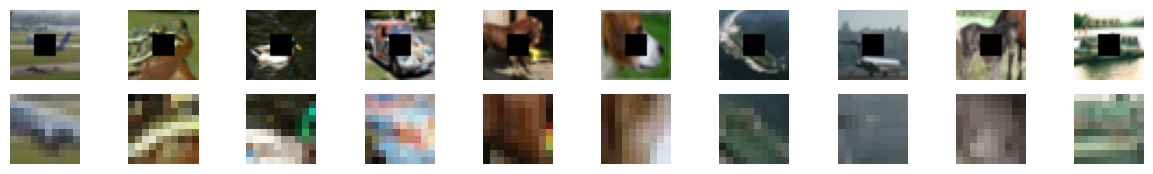

In [18]:
train_ds = load_dataset(TRAIN_NB_PATH)
train_ds_out = load_dataset(TRAIN_CROP_PATH)

fig, axes = plt.subplots(2, 10, figsize=(15, 2))
for i in range(10):
    axes[0][i].imshow(train_ds[i])
    axes[0][i].axis('off')
    axes[1][i].imshow(train_ds_out[i])
    axes[1][i].axis('off')
plt.show()

In [15]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras import backend as K

# Definisanje funkcije za postepeno smanjenje learning rate-a
def lr_schedule(epoch):
    if epoch % 50000 == 0 and epoch > 0:
        lr = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, lr * 0.8)
        print(f"Learning rate reduced to: {lr * 0.8}")
    return K.get_value(model.optimizer.lr)

# Promena optimizer-a na Adam
model.compile(optimizer=Adam(), loss='mse')

# Postavljanje veličine batch-a na 50
batch_size = 50

# Postavljanje weight decay parametra
weight_decay = 0.005

# Definisanje callback funkcije za smanjenje learning rate-a
lr_scheduler = LearningRateScheduler(lr_schedule)

# Treniranje modela bez sigmoidnog sloja


In [19]:
test_ds = load_dataset(TEST_NB_PATH)
test_ds_out = load_dataset(TEST_CROP_PATH)

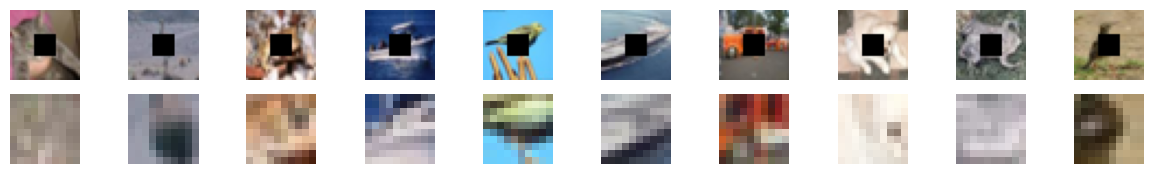

In [17]:
fig, axes = plt.subplots(2, 10, figsize=(15, 2))
for i in range(10):
    axes[0][i].imshow(test_ds[i])
    axes[0][i].axis('off')
    axes[1][i].imshow(test_ds_out[i])
    axes[1][i].axis('off')
plt.show()

To work with the data properly, it's neccessary to transfer them as np.array before passing to the NN

In [20]:
train_ds = np.array(train_ds)
train_ds_out = np.array(train_ds_out)
test_ds = np.array(test_ds)
test_ds_out = np.array(test_ds_out)

In [23]:
print('Train input images shape:', train_ds.shape)
print('Train output images shape:', train_ds_out.shape)
print('Test input images shape:', test_ds.shape)
print('Test output images shape:', test_ds_out.shape)

Train input images shape: (50000, 32, 32, 3)
Train output images shape: (50000, 300)
Test input images shape: (10000, 32, 32, 3)
Test output images shape: (10000, 300)


It is necessary to change the format of the output images so that they are in the same format that we get from the neural network

In [24]:
train_ds_out = np.reshape(train_ds_out, (train_ds_out.shape[0], 300))
test_ds_out = np.reshape(test_ds_out, (test_ds_out.shape[0], 300))

print('Train output images shape:', train_ds_out.shape)
print('Test output images shape:', test_ds_out.shape)

Train output images shape: (50000, 300)
Test output images shape: (10000, 300)


In [27]:
model.fit(train_ds, train_ds_out, batch_size=batch_size, epochs=10, callbacks=[lr_scheduler], validation_data=(test_ds, test_ds_out))


Epoch 1/10
1000/1000 [==============================] - 1227s 1s/step - loss: 2795.1895 - val_loss: 1706.6582 - lr: 0.0010
Epoch 2/10
1000/1000 [==============================] - 1175s 1s/step - loss: 1561.6497 - val_loss: 1454.5403 - lr: 0.0010
Epoch 3/10
1000/1000 [==============================] - 1201s 1s/step - loss: 1453.6090 - val_loss: 1429.1035 - lr: 0.0010
Epoch 4/10
1000/1000 [==============================] - 1173s 1s/step - loss: 1355.2457 - val_loss: 1343.6718 - lr: 0.0010
Epoch 5/10
1000/1000 [==============================] - 1203s 1s/step - loss: 1333.2841 - val_loss: 1439.9286 - lr: 0.0010
Epoch 6/10
1000/1000 [==============================] - 1175s 1s/step - loss: 1302.4769 - val_loss: 1326.6428 - lr: 0.0010
Epoch 7/10
1000/1000 [==============================] - 1177s 1s/step - loss: 1283.3525 - val_loss: 1391.3552 - lr: 0.0010
Epoch 8/10
1000/1000 [==============================] - 1204s 1s/step - loss: 1265.3511 - val_loss: 1321.2787 - lr: 0.0010
Epoch 9/10
1000/

In [3]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CIFAR-10"

In [29]:
model.save(MODEL_PATH + "/model.h5")

# Load trained model and show prediction

In [13]:
MODEL_PATH = "/content/drive/MyDrive/Colab Notebooks/ImageInpainting/CIFAR-10"

In [14]:
def full_image(nb_img, center):
  modified_image = np.copy(nb_img)
  center_x = nb_img.shape[0] // 2
  center_y = nb_img.shape[1] // 2
  modified_image[center_x-5:center_x+5, center_y-5:center_y+5, :] = center

  return modified_image

In [15]:
from keras.models import load_model

model = load_model(MODEL_PATH + "/model.h5")

In [43]:
data = test_ds[:10]
output = test_ds_out[:10]

predictions = model.predict(data)
'''
prediction_image = np.reshape(predictions, (10, 10, 3))

fig = plt.figure(figsize=(15, 2))
plt.imshow(full_image(data,prediction_image))
plt.axis('off')
plt.show()
'''

1/1 [==============================] - 0s 62ms/step


"\nprediction_image = np.reshape(predictions, (10, 10, 3))\n\nfig = plt.figure(figsize=(15, 2))\nplt.imshow(full_image(data,prediction_image))\nplt.axis('off')\nplt.show()\n"

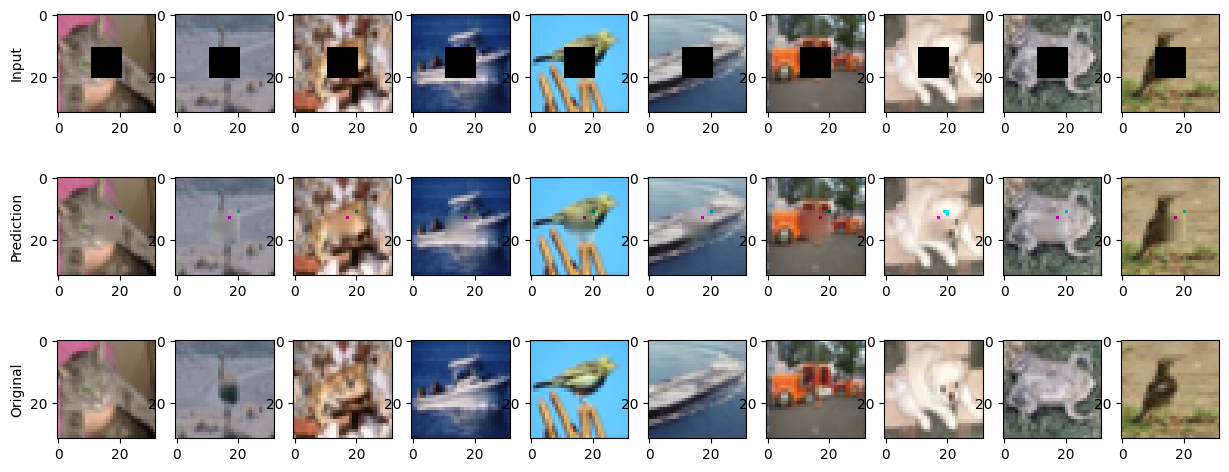

In [44]:
fig, axes = plt.subplots(3, 10, figsize=(15, 6))
for i in range(10):
    prediction_image = np.reshape(predictions[i], (10, 10, 3))

    axes[0][i].imshow(data[i])
    #axes[0][i].axis('off')
    axes[1][i].imshow(full_image(data[i],prediction_image))
    #axes[1][i].axis('off')

    org_image = np.reshape(output[i], (10, 10, 3))
    axes[2][i].imshow(full_image(data[i],org_image))
    #axes[2][i].axis('off')

axes[0][0].set_ylabel("Input")
axes[1][0].set_ylabel("Prediction")
axes[2][0].set_ylabel("Original")
plt.show()

In [30]:
#model_sigmoid.fit(train_images, train_labels, batch_size=batch_size, epochs=10, callbacks=[lr_scheduler], validation_data=(test_images, test_labels))
